In [ ]:
!pip install torchvision numpy matplotlib torch

Defaulting to user installation because normal site-packages is not writeable


# MINST Digit Generation using GAN
這段程式使用生成對抗網路（GAN）生成類似於MNIST數據集中手寫數字的假數據。
MNIST數據集中包含數字0到9的手寫數字圖像，目的是生成與此數據相似的假數據。

In [ ]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 載入數據並進行探索

In [ ]:
# 定義數據轉換操作：將數據轉換為Tensor格式
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data',  # 數據保存的路徑
                          train=True,     # 指定為訓練數據集
                          download=True,  # 如果數據未下載，則下載
                          transform=transform)

In [ ]:
# 輸出數據的基本資訊
print(train_ds.data.shape)  # 訓練數據的形狀
print(train_ds.targets.shape)  # 訓練數據對應的標籤
print(train_ds.classes)  # 數據集的分類
print(train_ds.data[0])  # 第一個圖像的像素值
print(train_ds.targets[0])  # 第一個圖像的標籤
print(train_ds.data[0].max())  # 圖像的最大像素值
print(train_ds.data[0].min())  # 圖像的最小像素值
print(train_ds.data[0].float().mean())  # 圖像的平均值
print(train_ds.data[0].float().std())  # 圖像的標準差

torch.Size([60000, 28, 28])
torch.Size([60000])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   

In [ ]:
# 建立數據加載器，將數據分批次加載
dl = DataLoader(dataset=train_ds,  # 數據集
                shuffle=True,      # 隨機打亂數據
                batch_size=64)     # 每批次的大小

In [ ]:
# 檢查數據加載器加載的樣本批次
image_batch = next(iter(dl))  # 獲取一個批次的數據
print(len(image_batch), type(image_batch))  # 輸出批次的長度與類型
print(image_batch[0].shape)  # 圖像批次的形狀
print(image_batch[1].shape)  # 對應標籤的形狀

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


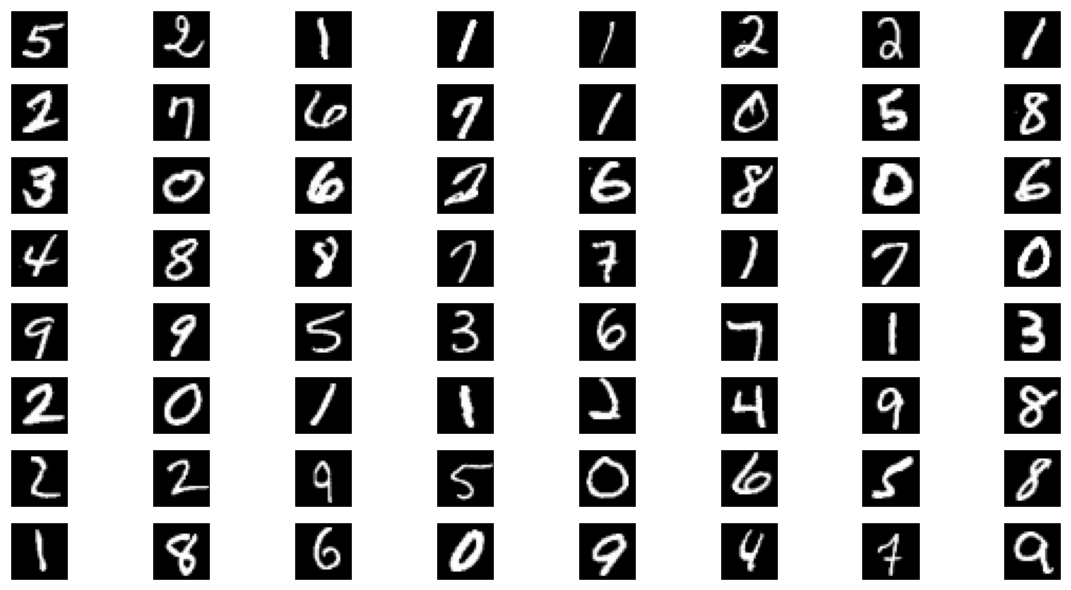

In [ ]:
## ----------------------------------------------------------------------------
## 視覺化一個數據批次
## ----------------------------------------------------------------------------

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    功能：在網格中顯示一組圖像

    參數
    ----------
    images: Tensor
        包含要顯示的圖像的張量
    n_cols: int
        網格中的列數
    figsize: tuple
        圖像的大小
    """
    plt.style.use('ggplot')  # 使用ggplot樣式
    n_images = len(images)  # 獲取圖像數量
    n_rows = math.ceil(n_images / n_cols)  # 計算行數
    plt.figure(figsize=figsize)  # 設置圖像大小
    for idx in range(n_images):  # 遍歷所有圖像
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        image = images[idx]
        # 調整維度為 H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis  # 根據通道數決定顏色
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])  # 移除X軸標籤
        ax.set_yticks([])  # 移除Y軸標籤
    plt.tight_layout()
    plt.show()

# 顯示圖像，網格列數為8
display_images(images=image_batch[0], n_cols=8)

## 定義網路結構

### 判別器網路

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # 判別器網路結構：逐步下採樣輸入，生成二元輸出
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)  # 使用LeakyReLU激活函數
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)  # 添加Dropout防止過擬合

    def forward(self, x):
        # 將輸入圖像展平
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # 前向傳播
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)
        logit_out = self.fc4(x)  # 最後一層輸出為logits

        return logit_out

### 生成器網路

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # 生成器網路結構：逐步上採樣輸入，生成與判別器輸入大小一致的圖像
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)  # 使用LeakyReLU激活函數
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)  # 添加Dropout防止過擬合
        self.tanh = nn.Tanh()  # 使用tanh函數壓縮輸出到[-1,1]範圍

    def forward(self, x):
        # 前向傳播
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)  # 輸出為tanh函數壓縮的數據

        return tanh_out

## 定義損失函數

In [ ]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    計算對於真實數據的損失

    參數
    ----------
    predicted_outputs: Tensor
        判別器對真實數據的預測輸出
    loss_fn: nn.Module
        使用的損失函數（例如 BCEWithLogitsLoss）
    device: str
        訓練設備（例如 'cpu' 或 'cuda'）

    返回值
    -------
    real_loss: Tensor
        真實數據的損失值
    """
    batch_size = predicted_outputs.shape[0]
    # 將目標設為全1，因為判別器應該預測為真實
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    計算對於假數據的損失

    參數
    ----------
    predicted_outputs: Tensor
        判別器對假數據的預測輸出
    loss_fn: nn.Module
        使用的損失函數（例如 BCEWithLogitsLoss）
    device: str
        訓練設備（例如 'cpu' 或 'cuda'）

    返回值
    -------
    fake_loss: Tensor
        假數據的損失值
    """
    batch_size = predicted_outputs.shape[0]
    # 將目標設為全0，因為判別器應該預測為假
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    return fake_loss

## 訓練網路
在訓練過程中，需要為判別器和生成器分別定義優化器。

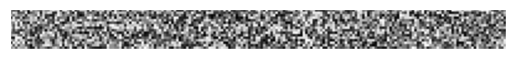

In [ ]:
# 初始化一組隨機的潛在向量，用於視覺化生成器的進展
z_size = 200 #潛在向量的大小
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
# 訓練迴圈函數
def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    """
    訓練GAN模型，包括生成器和判別器。

    參數
    ----------
    d: Discriminator
        判別器模型
    g: Generator
        生成器模型
    d_optim: torch.optim.Optimizer
        判別器的優化器
    g_optim: torch.optim.Optimizer
        生成器的優化器
    loss_fn: nn.Module
        損失函數（例如 BCEWithLogitsLoss）
    dl: DataLoader
        MNIST數據集的數據加載器
    n_epochs: int
        訓練的輪數
    device: str
        訓練設備（例如 'cpu' 或 'cuda'）
    verbose: bool
        是否顯示訓練過程中的詳細資訊

    返回值
    -------
    d_losses: list
        判別器的損失隨時間變化的記錄
    g_losses: list
        生成器的損失隨時間變化的記錄
    """
    print(f'開始在 [{device}] 上訓練...')

    # 初始化一個固定的潛在向量，用於生成器的進展視覺化
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)

    # 儲存生成的樣本與損失記錄
    fixed_samples = []
    d_losses = []
    g_losses = []

    # 將模型移動到指定設備
    d = d.to(device)
    g = g.to(device)

    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0

        # 遍歷數據加載器中的每個批次
        for curr_batch, (real_images, _) in enumerate(dl):
            # 移動數據到指定設備
            real_images = real_images.to(device)

            ## 訓練判別器
            d_optim.zero_grad()  # 重置梯度
            real_images = (real_images * 2) - 1  # 將像素範圍從 [0,1] 映射到 [-1,1]
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)

            with torch.no_grad():
                # 生成一批假數據
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                fake_images = g(z)
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)

            # 判別器的總損失
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optim.step()

            d_running_batch_loss += d_loss

            ## 訓練生成器
            g_optim.zero_grad()
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            fake_images = g(z)
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            g_loss.backward()
            g_optim.step()

            g_running_batch_loss += g_loss

            # 每400批次顯示訓練狀態
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch}/{len(dl)}] - d_loss: {d_loss.item():.6f}, g_loss: {g_loss.item():.6f}')

        # 記錄每輪的損失
        d_losses.append(d_running_batch_loss.item() / len(dl))
        g_losses.append(g_running_batch_loss.item() / len(dl))

        print(f'epoch_d_loss: {d_losses[-1]:.6f} \tepoch_g_loss: {g_losses[-1]:.6f}')

        # 用固定的潛在向量生成假數據並儲存
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())

    # 儲存生成的假數據
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)

    return d_losses, g_losses

In [ ]:
##
## 開始訓練模型
##

# 設定GAN訓練參數
d = Discriminator(in_features=784, out_features=1)  # 初始化判別器
g = Generator(in_features=200, out_features=784)  # 初始化生成器
d_optim = optim.Adam(d.parameters(), lr=0.002)  # 判別器優化器
g_optim = optim.Adam(g.parameters(), lr=0.002)  # 生成器優化器
loss_fn = nn.BCEWithLogitsLoss()  # 損失函數
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # 設置訓練設備
n_epochs = 2000  # 訓練回合數

# 指定訓練設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 訓練GAN模型
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device)

開始在 [cuda] 上訓練...
Epoch [1/2000]:
epoch_d_loss: 1.184534 	epoch_g_loss: 1.408480
Epoch [2/2000]:
epoch_d_loss: 1.162731 	epoch_g_loss: 1.213009
Epoch [3/2000]:
epoch_d_loss: 1.166710 	epoch_g_loss: 1.188772
Epoch [4/2000]:
epoch_d_loss: 1.032043 	epoch_g_loss: 1.561303
Epoch [5/2000]:
epoch_d_loss: 0.988514 	epoch_g_loss: 1.726119
Epoch [6/2000]:
epoch_d_loss: 1.069995 	epoch_g_loss: 1.461883
Epoch [7/2000]:
epoch_d_loss: 1.080431 	epoch_g_loss: 1.336262
Epoch [8/2000]:
epoch_d_loss: 1.127562 	epoch_g_loss: 1.154838
Epoch [9/2000]:
epoch_d_loss: 1.175750 	epoch_g_loss: 1.069917
Epoch [10/2000]:
epoch_d_loss: 1.217330 	epoch_g_loss: 1.006836
Epoch [11/2000]:
epoch_d_loss: 1.228490 	epoch_g_loss: 0.979366
Epoch [12/2000]:
epoch_d_loss: 1.260213 	epoch_g_loss: 0.920308
Epoch [13/2000]:
epoch_d_loss: 1.262149 	epoch_g_loss: 0.920004
Epoch [14/2000]:
epoch_d_loss: 1.235026 	epoch_g_loss: 0.979968
Epoch [15/2000]:
epoch_d_loss: 1.225432 	epoch_g_loss: 0.990926
Epoch [16/2000]:
epoch_d_loss: 

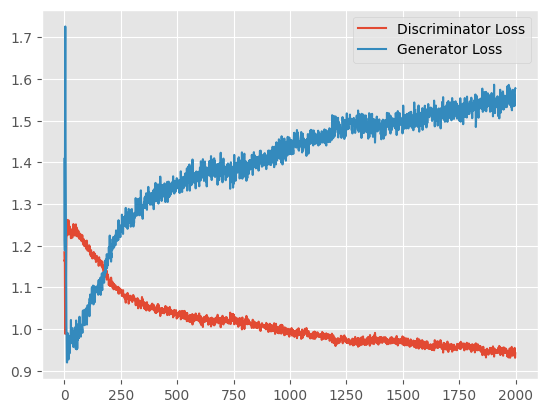

In [ ]:
# 視覺化訓練損失
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.legend()
plt.show()

In [ ]:
##
## 視覺化生成器生成的圖像

def show_generated_images(epoch, n_cols=8):
    """
    顯示指定訓練輪數生成器生成的假數據圖像

    參數
    ----------
    epoch: int
        要顯示的訓練輪數
    n_cols: int
        每行顯示的圖像數量

    返回值
    -------
    None
    """
    # 載入之前儲存的生成樣本
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]  # 獲取指定輪數的假數據
    # 將生成的數據範圍從 [-1, 1] 映射回 [0, 1]
    epoch_data = (epoch_data + 1) / 2
    # 調整數據形狀為 (批次大小, 通道數, 高度, 寬度)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    # 顯示圖像
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

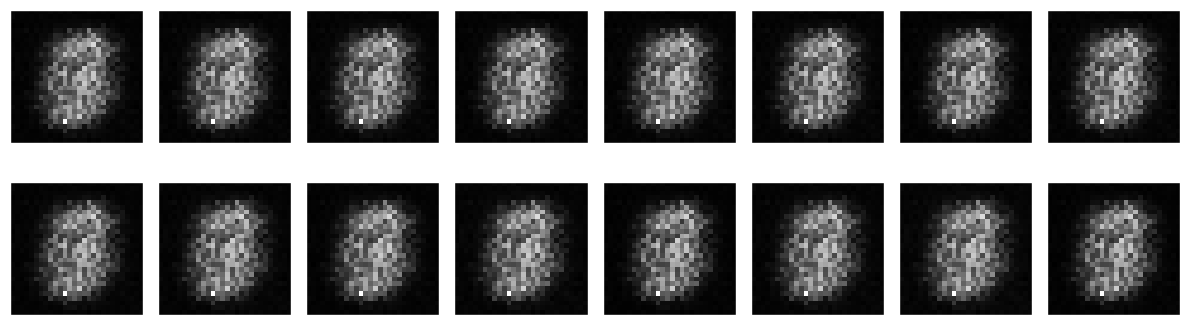

In [ ]:
# 在指定輪數顯示生成的圖像
show_generated_images(epoch=1, n_cols=8)

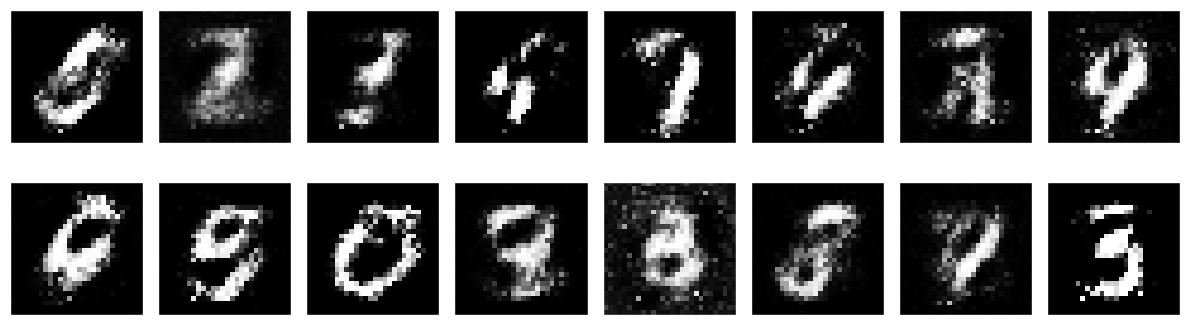

In [ ]:
show_generated_images(epoch=10, n_cols=8)

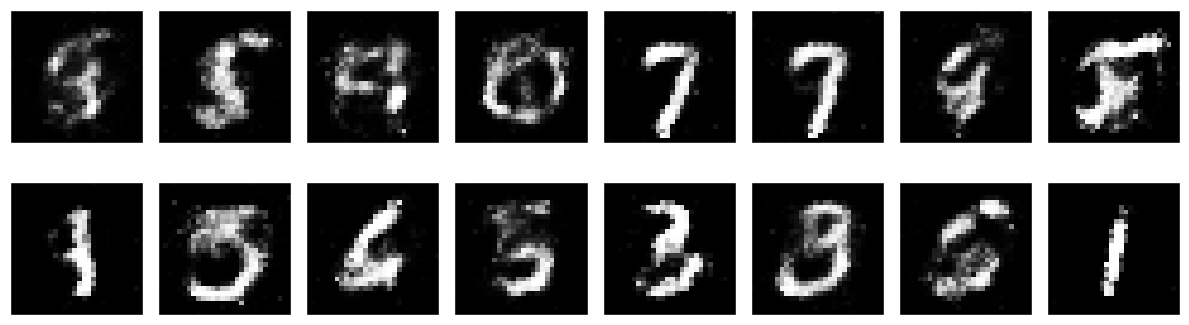

In [ ]:
show_generated_images(epoch=50, n_cols=8)

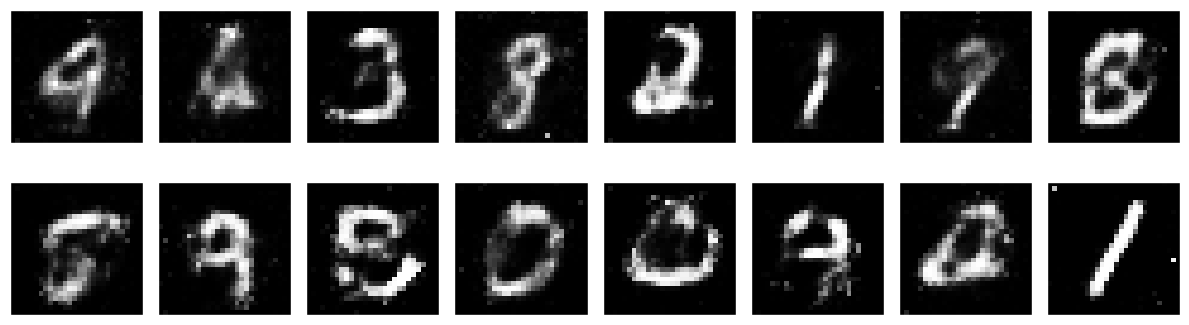

In [ ]:
show_generated_images(epoch=100, n_cols=8)

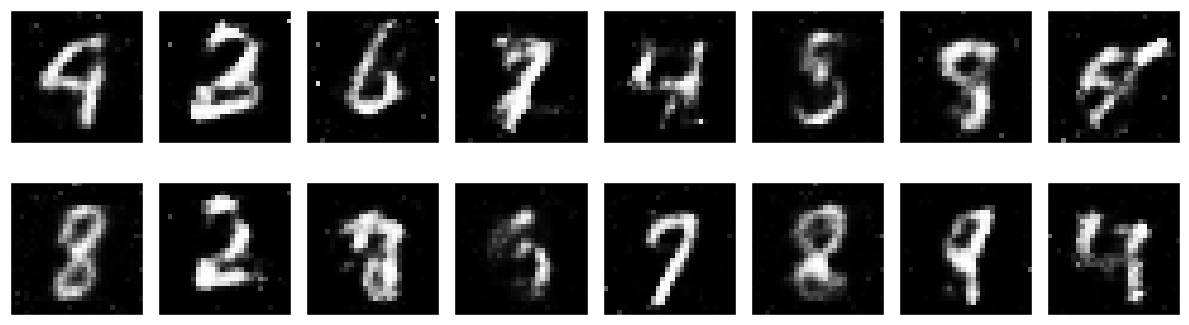

In [ ]:
show_generated_images(epoch=200, n_cols=8)

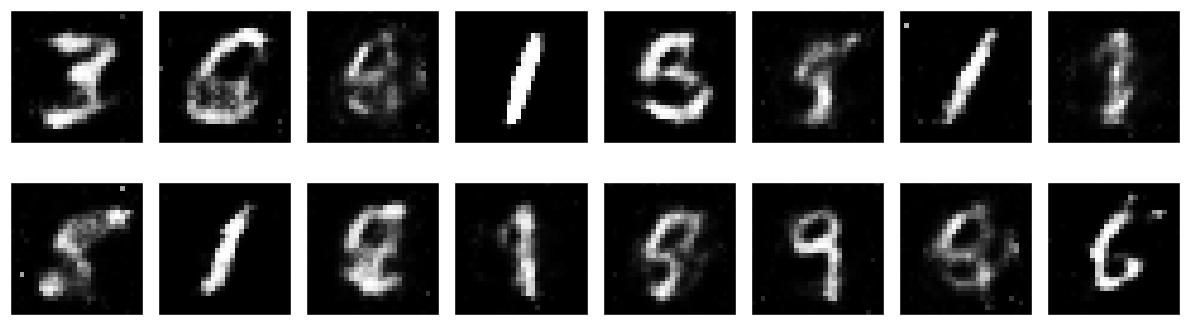

In [ ]:
show_generated_images(epoch=300, n_cols=8)

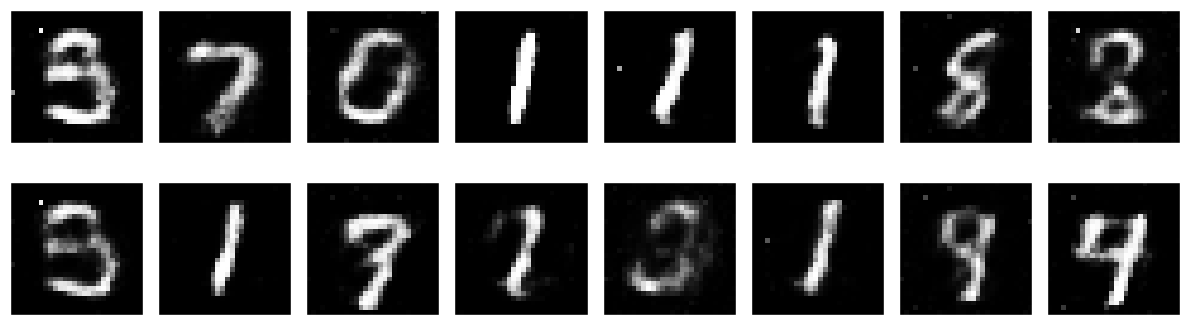

In [ ]:
show_generated_images(epoch=400, n_cols=8)

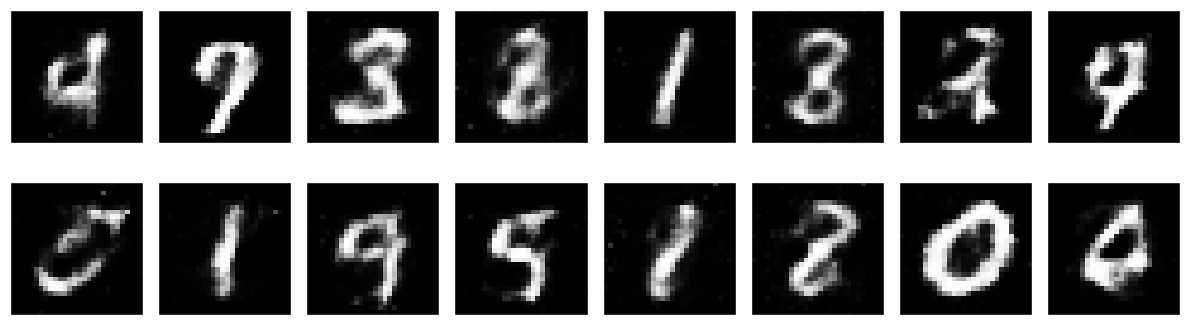

In [ ]:
show_generated_images(epoch=500, n_cols=8)

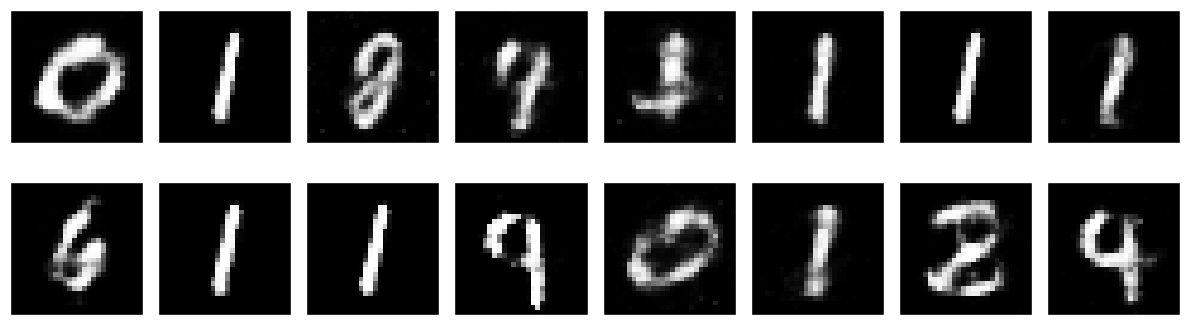

In [ ]:
show_generated_images(epoch=1000, n_cols=8)

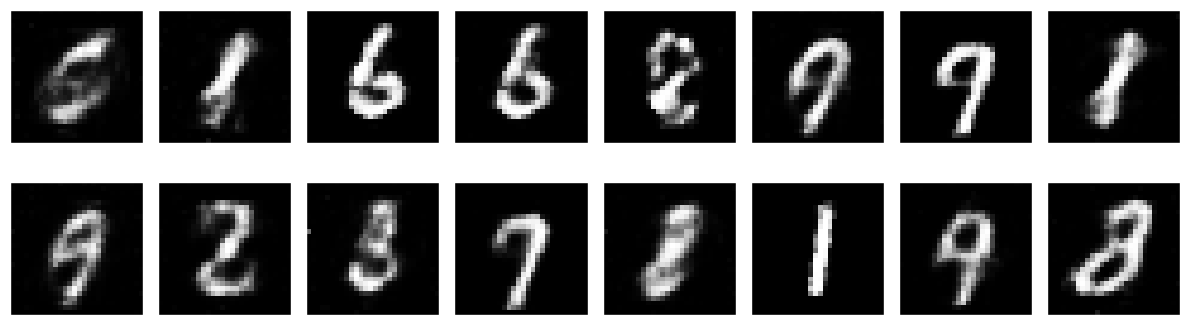

In [ ]:
show_generated_images(epoch=1show_generated_images(epoch=500, n_cols=8)500, n_cols=8)

## 測試生成器
經過訓練後的生成器可以用來生成與MNIST數據集相似的假手寫數字。
在這個階段，判別器的作用已完成，可以捨棄。

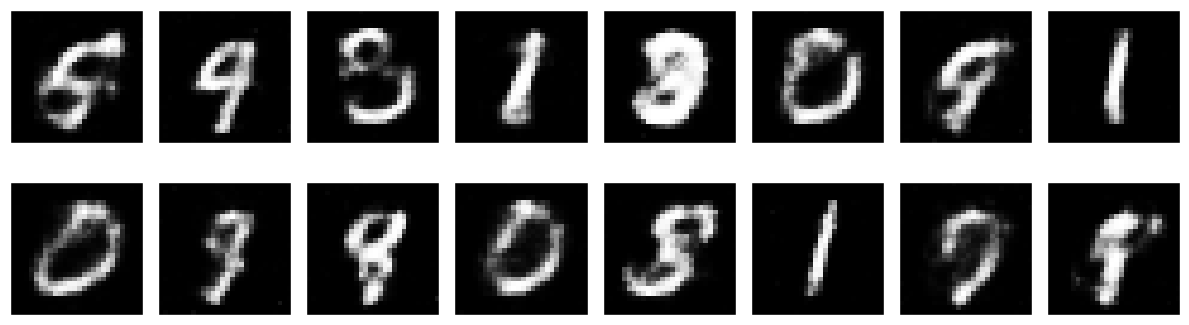

In [ ]:
show_generated_images(epoch=2000, n_cols=8)

In [ ]:
# 確保生成器在 CPU 並設置為評估模式
g.to('cpu')
g.eval()

# 生成一個潛在向量
z = np.random.uniform(-1, 1, size=(dl.batch_size, 200))  # 確認 dl.batch_size 與生成器設計匹配
z = torch.from_numpy(z).float().to('cpu')  # 確保張量在 CPU

# 使用生成器生成假圖像
fake_image = g(z)

# 調整形狀
fake_image = fake_image.view(-1, 1, 28, 28).detach()  # 自動推斷批次大小，轉換為 28x28 圖像

# 顯示圖像
display_images(fake_image, n_cols=1, figsize=(2, 2))


/tmp/ipykernel_118830/4285059447.py:31: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
